# LSTM Training

In [7]:
import sys
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import os

In [8]:
# convert series to supervised learning
# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
#     n_vars = 1 if type(data) is list else data.shape[1]
#     df = DataFrame(data)
#     cols, names = list(), list()
#     # input sequence (t-n, ... t-1)
#     for i in range(n_in, 0, -1):
#         cols.append(df.shift(i))
#         names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
#     # forecast sequence (t, t+1, ... t+n)
#     for i in range(0, n_out):
#         cols.append(df.shift(-i))
#         if i == 0:
#             names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
#         else:
#             names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
#     # put it all together
#     agg = concat(cols, axis=1)
#     agg.columns = names
#     # drop rows with NaN values
#     if dropnan:
#         agg.dropna(inplace=True)
#     return agg

In [9]:
# load dataset
dataset = read_csv('../datasets/bss/dublin/reorg/station_2.csv')
# dataset = read_csv('datasets/bss/dublin/reorg_plus_weather/station_2.csv')

dataset = dataset.drop('TIME', axis=1)
# dataset = dataset.drop('date', axis=1)
# print(dataset.head())
values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = scaled

print(scaled)

[[0.         0.5226481  0.58082193 0.5       ]
 [0.         0.5261324  0.58082193 0.5       ]
 [0.         0.5296167  0.58082193 0.5       ]
 ...
 [0.05       0.9930314  0.         0.8333334 ]
 [0.05       0.9965157  0.         0.8333334 ]
 [0.05       1.         0.         0.8333334 ]]


In [10]:
# split into train and test sets
# values = reframed.values

train_start = 0
train_end = 8760

test_start = 99144
test_end = 108071

n_train_hours = 365 * 24
train = scaled[train_start:train_end, :]
test = scaled[test_start:test_end, :]
# train = values[train_start:train_end, :]
# test = values[test_start:test_end, :]

# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 3) (8760,) (8927, 1, 3) (8927,)


Epoch 1/150
122/122 [==============================] - 5s 11ms/step - loss: 0.2525 - val_loss: 0.2152
Epoch 2/150
122/122 [==============================] - 1s 4ms/step - loss: 0.2419 - val_loss: 0.2154
Epoch 3/150
122/122 [==============================] - 1s 4ms/step - loss: 0.2405 - val_loss: 0.2159
Epoch 4/150
122/122 [==============================] - 1s 4ms/step - loss: 0.2399 - val_loss: 0.2166
Epoch 5/150
122/122 [==============================] - 1s 4ms/step - loss: 0.2395 - val_loss: 0.2184
Epoch 6/150
122/122 [==============================] - 1s 4ms/step - loss: 0.2400 - val_loss: 0.2188
Epoch 7/150
122/122 [==============================] - 1s 4ms/step - loss: 0.2395 - val_loss: 0.2192
Epoch 8/150
122/122 [==============================] - 1s 4ms/step - loss: 0.2392 - val_loss: 0.2198
Epoch 9/150
122/122 [==============================] - 1s 4ms/step - loss: 0.2391 - val_loss: 0.2207
Epoch 10/150
122/122 [==============================] - 1s 4ms/step - loss: 0.2388 - val_l

122/122 [==============================] - 1s 4ms/step - loss: 0.1792 - val_loss: 0.1517
Epoch 82/150
122/122 [==============================] - 1s 4ms/step - loss: 0.1791 - val_loss: 0.1517
Epoch 83/150
122/122 [==============================] - 1s 4ms/step - loss: 0.1790 - val_loss: 0.1517
Epoch 84/150
122/122 [==============================] - 1s 4ms/step - loss: 0.1789 - val_loss: 0.1516
Epoch 85/150
122/122 [==============================] - 1s 5ms/step - loss: 0.1787 - val_loss: 0.1516
Epoch 86/150
122/122 [==============================] - 1s 4ms/step - loss: 0.1787 - val_loss: 0.1516
Epoch 87/150
122/122 [==============================] - 1s 4ms/step - loss: 0.1786 - val_loss: 0.1517
Epoch 88/150
122/122 [==============================] - 1s 4ms/step - loss: 0.1785 - val_loss: 0.1516
Epoch 89/150
122/122 [==============================] - 1s 4ms/step - loss: 0.1784 - val_loss: 0.1516
Epoch 90/150
122/122 [==============================] - 1s 4ms/step - loss: 0.1783 - val_loss: 

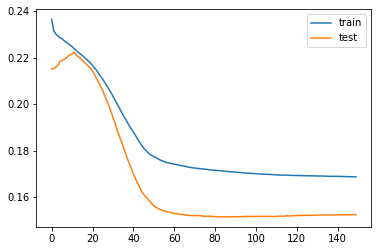

In [11]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y,
                    epochs=150,
                    batch_size=72,
                    validation_data=(test_X, test_y),
                    verbose=1,
                    shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [12]:
# make a prediction
yhat = model.predict(test_X)
# print(test_X)
# print(yhat)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE

# np.set_printoptions(threshold=sys.maxsize)
# temp = concatenate((inv_y, inv_yhat))
# print(temp)
# print(inv_y)
# print(inv_yhat)

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
mse = mean_squared_error(inv_y, inv_yhat)
r2 = r2_score(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test R2: %.30f' % r2)



Test MAE: 3.052
Test MSE: 17.707
Test RMSE: 4.208
Test R2: 0.400523587599159847094654196553
